In [33]:
import itertools
import json
import pickle
from pathlib import Path
from collections import defaultdict
from pprint import pprint

import numpy as np
import pandas as pd
import flowkit as fk
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

import ipywidgets as widgets
from ipydatagrid import Expr, DataGrid, TextRenderer, BarRenderer
from tqdm.notebook import tqdm

from utils import ask_directory
from logicle_scaling import LogicleTransform
from pair_precision import (
    get_bin_centers,
    inverse_logicle,
    get_logicle_polygon_gates,
    get_pair_precisions
)


SEED = 7
np.random.seed(SEED)

In [3]:
# load config from the previous step, if it's available
config = {}
config_file = Path("./config.json")
if config_file.exists():
    with open(config_file, mode="r") as f:
        config = json.load(f)

config

{'raw_data_dir': '/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data',
 'logicle_data_dir': '/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data'}

In [6]:
raw_data_dir = config.get("raw_data_dir", None)

if raw_data_dir is None:
    raw_data_dir = ask_directory("Select your data directory")

raw_data_dir = Path(raw_data_dir)
print(raw_data_dir)

/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data


### Select the Logicle transformed directory:

In [7]:
transformed_data_dir = config.get("logicle_data_dir", None)
if transformed_data_dir is None:
    transformed_data_dir = ask_directory("Select directory of the transformed data")

transformed_data_dir = Path(transformed_data_dir)
print(transformed_data_dir)

/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data


In [8]:
logicle_samples = {}
h5_files = transformed_data_dir.glob("*.h5")
for file in h5_files:
    logicle_samples[file.stem] = file

pprint(logicle_samples)

{'C.6818': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/C.6818.h5'),
 'Emiliana_huxley': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Emiliana_huxley.h5'),
 'Lingodinium': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Lingodinium.h5'),
 'Phaeodactylum': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Phaeodactylum.h5'),
 'Skeletonema': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Skeletonema.h5'),
 'Synechococcus': PosixPath('/Users/mehdi.seifi/Projects/AI4Life/project_10_sorting/data/transformed_data/Synechococcus.h5')}


### Select the target species:

In [9]:
selector = widgets.Select(
    options=[sp_name for sp_name in logicle_samples],
    rows=14,
    description="Select Target Sample:"
)

display(selector)

Select(description='Select Target Sample:', options=('Synechococcus', 'Lingodinium', 'C.6818', 'Phaeodactylum'…

In [10]:
target_species = selector.value
print(f"Your target species: {target_species}")

Your target species: Skeletonema


### Load the thresholded similarity mask from the previous step:

In [11]:
high_sim_mask = np.load(f"./results/{target_species}_high_sim_mask.npy")
high_sim_mask.shape

(540631,)

### Select gates (channel pairs) for the gating strategy:
You can select multiple rows (hold Ctrl/CMD or Shift)

In [12]:
# load pair precisions result
df_pair_precisions = pd.read_csv(f"./results/{target_species}_gate_precisions.csv")
df_pair_precisions.index += 1

In [13]:
datagrid = DataGrid(
    df_pair_precisions,
    base_row_header_size=40, base_column_header_size=40,
    base_row_size=30, base_column_size=150,
    selection_mode="row", auto_fit_columns=True
)
datagrid

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, base_column_h…

In [14]:
selected_rows = list(set([cell["r"] for cell in datagrid.selected_cells]))
df_selected_pairs = df_pair_precisions.iloc[selected_rows]
df_selected_pairs

,channel_1,channel_2,fisher_avg,precision,TP,FP
1,V14 (675)-H,B13 (750)-H,5.6545,95.02,15287,801
2,Size (Red*),V13 (655)-A,5.2998,94.06,14373,907
3,UV16 (675)-H,B13 (750)-H,5.5856,93.28,16126,1162
9,V16 (725)-H,B14 (780)-H,5.9119,90.19,14786,1609


### Load logicle parameters for inverse transform.

In [15]:
# get the target species logicle params
df_logicle_params = pd.read_hdf(logicle_samples[target_species], key="logicles")
df_logicle_params.shape

(421, 4)

In [16]:
logicle_params = [
    df_logicle_params.loc[[row[0], row[1]]].to_numpy() for row in
    df_selected_pairs.itertuples(index=False, name=None)
]

### Select all samples (*.fcs) as the sterategy inputs:
(Hold Ctrl/CMD or Shift)

In [17]:
raw_data_dir = Path(raw_data_dir)
fcs_files = raw_data_dir.glob("**/*.fcs")
sample_paths = {}
for fcs in fcs_files:
    # has_images = len(list(fcs.parent.glob("*images"))) > 0
    # if has_images:
    sample_paths[fcs.stem] = fcs

# pprint(sample_paths)
selector = widgets.SelectMultiple(
    options=[sp_name for sp_name in sample_paths],
    rows=14,
    description="Select input samples:"
)

display(selector)

SelectMultiple(description='Select input samples:', options=('Amphidinium', 'Skeletonema', 'Lingodinium', 'C.6…

In [18]:
input_samples = [
    fk.Sample(sample_paths[name], sample_id=name)
    for name in selector.value
]
input_samples

[Sample(v3.2, Skeletonema, 450 channels, 540631 events),
 Sample(v3.2, Lingodinium, 450 channels, 893258 events),
 Sample(v3.2, C.6818, 450 channels, 299976 events),
 Sample(v3.2, Emiliana_huxley, 450 channels, 126206 events),
 Sample(v3.2, Phaeodactylum, 450 channels, 238981 events),
 Sample(v3.2, Synechococcus, 450 channels, 11927 events)]

### Generate the gating strategy based on the selected pairs:

In [21]:
def get_logicle_polygon(high_sim_data):
    high_sim_bin_centers = get_bin_centers(high_sim_data)
    try:
        # get convex hull polygon
        hull = ConvexHull(high_sim_bin_centers)
        polygon = high_sim_bin_centers[hull.vertices]
    except Exception:
        polygon = None

    return polygon

In [22]:
def run_session(gating, input_samples):
    session = fk.Session(
        gating_strategy=gating,
        fcs_samples=input_samples
    )
    session.analyze_samples(use_mp=True, verbose=False)

    return session

In [23]:
df_positive_logicle = pd.read_hdf(logicle_samples[target_species], key="df")
df_positive_logicle.shape

(540631, 421)

In [24]:
gating = fk.GatingStrategy()
parents = ["root"]

sim_mask = high_sim_mask.copy()
logicle_polygons = []
data_polygons = []
count = 0

for row in tqdm(
    df_selected_pairs.itertuples(index=False, name=None),
    total=len(df_selected_pairs) ,desc="Generating gating strategy"
):
    ch1 = row[0]
    ch2 = row[1]
    sim_data = df_positive_logicle[[ch1, ch2]][sim_mask].to_numpy()
    logicle_polygon = get_logicle_polygon(sim_data)
    logicle_polygons.append(logicle_polygon)

    if logicle_polygon is not None:
        data_polygon = inverse_logicle(logicle_polygon, logicle_params[count])
        data_polygons.append(data_polygon)
        # create and add the gate
        dim1 = fk.Dimension(ch1)
        dim2 = fk.Dimension(ch2)
        gate = fk.gates.PolygonGate(
            gate_name=f"g{count + 1}", dimensions=[dim1, dim2],
            vertices=data_polygon.tolist()
        )
        gating.add_gate(gate, tuple(parents))
        # run gating in a session
        session = run_session(gating, input_samples)
        target_in = session.get_gate_membership(target_species, gate.gate_name)
        sim_mask = sim_mask & target_in
        print(f"number of targets passed through the gate: {target_in.sum()}")

        parents.append(f"g{count + 1}")
        count += 1

Generating gating strategy:   0%|          | 0/4 [00:00<?, ?it/s]

number of targets passed through the gate: 15287
number of targets passed through the gate: 13890
number of targets passed through the gate: 13492
number of targets passed through the gate: 13218


In [25]:
gating.get_gate_hierarchy()

'root\n╰── g1\n    ╰── g2\n        ╰── g3\n            ╰── g4'

### Stetragy results:

In [29]:
session = run_session(gating, input_samples)
df_report = session.get_analysis_report()
df_report

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
0,C.6818,"(root,)",g1,PolygonGate,None,root,137,0.045670,0.045670,1
1,C.6818,"(root, g1)",g2,PolygonGate,None,g1,0,0.000000,0.000000,2
2,C.6818,"(root, g1, g2)",g3,PolygonGate,None,g2,0,0.000000,0.000000,3
3,C.6818,"(root, g1, g2, g3)",g4,PolygonGate,None,g3,0,0.000000,0.000000,4
0,Emiliana_huxley,"(root,)",g1,PolygonGate,None,root,82,0.064973,0.064973,1
1,Emiliana_huxley,"(root, g1)",g2,PolygonGate,None,g1,3,0.002377,3.658537,2
2,Emiliana_huxley,"(root, g1, g2)",g3,PolygonGate,None,g2,1,0.000792,33.333333,3
3,Emiliana_huxley,"(root, g1, g2, g3)",g4,PolygonGate,None,g3,0,0.000000,0.000000,4
0,Lingodinium,"(root,)",g1,PolygonGate,None,root,106,0.011867,0.011867,1
1,Lingodinium,"(root, g1)",g2,PolygonGate,None,g1,3,0.000336,2.830189,2


In [30]:
print(target_species)

df_last_gate = df_report[df_report["gate_name"] == f"g{len(logicle_polygons)}"]
df_last_gate[["sample", "gate_name", "count"]].groupby(["sample"]).sum()

Skeletonema


,gate_name,count
sample,,
C.6818,g4,0
Emiliana_huxley,g4,0
Lingodinium,g4,0
Phaeodactylum,g4,2
Skeletonema,g4,13218
Synechococcus,g4,0


### Save the workspace:

In [31]:
Path("./workspaces").mkdir(exist_ok=True)
session.export_wsp(f"./workspaces/{target_species}_gating_strategy.wsp", "samples")

### Ploting the gates

In [32]:
# gate visualization

df_target = pd.read_hdf(logicle_samples[target_species], key="df")

others_sample_ids = []
df_others = []
for sample_name in logicle_samples:
    if sample_name != target_species:
        others_sample_ids.append(sample_name)
        df_others.append(pd.read_hdf(logicle_samples[sample_name], key="df"))

# df_others = pd.concat(df_others)



Skeletonema: 15,287
Synechococcus: 1
Lingodinium: 106
C.6818: 137
Phaeodactylum: 475
Emiliana_huxley: 82


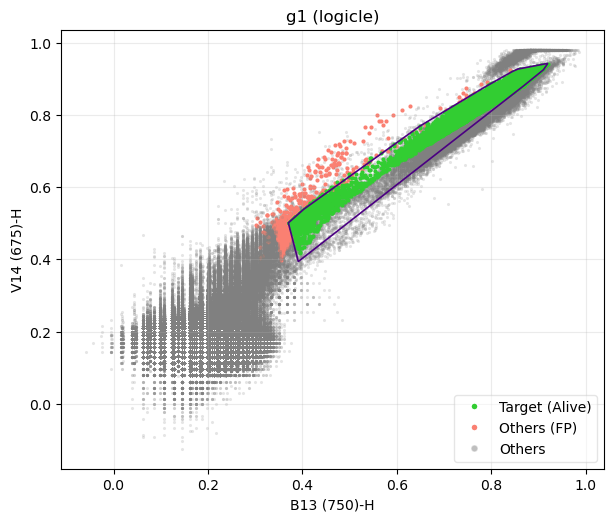



Skeletonema: 13,890
Synechococcus: 0
Lingodinium: 3
C.6818: 0
Phaeodactylum: 12
Emiliana_huxley: 3


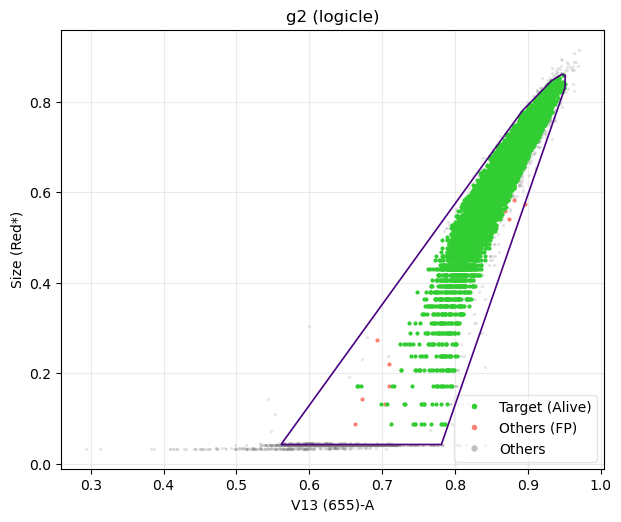



Skeletonema: 13,492
Synechococcus: 0
Lingodinium: 0
C.6818: 0
Phaeodactylum: 3
Emiliana_huxley: 1


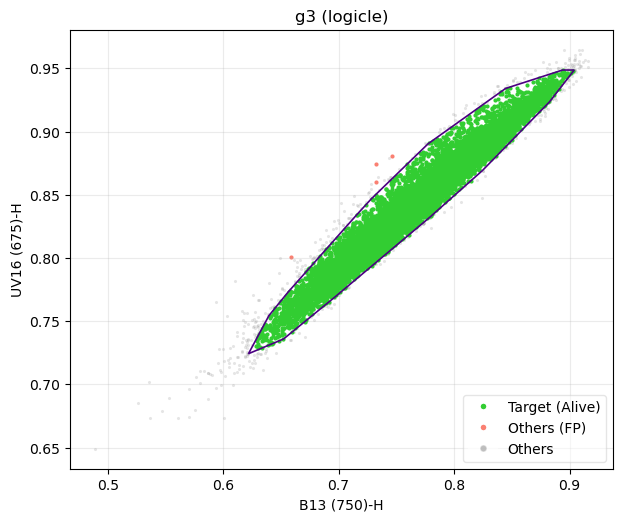



Skeletonema: 13,218
Synechococcus: 0
Lingodinium: 0
C.6818: 0
Phaeodactylum: 2
Emiliana_huxley: 0


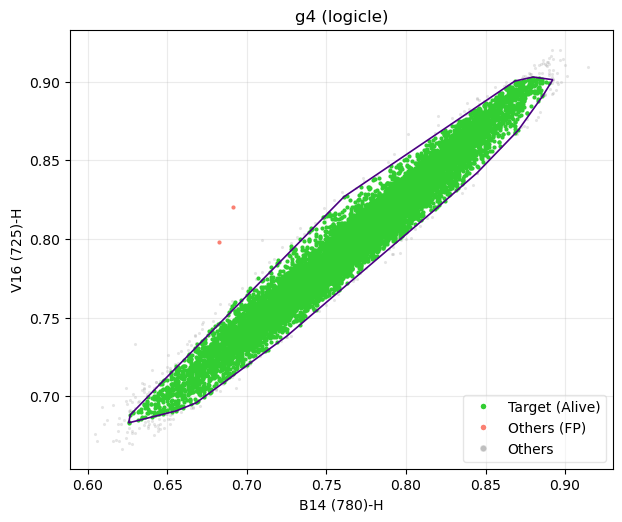

In [48]:
count = 0
all_memberships = defaultdict(list)

for i, row in df_selected_pairs.iterrows():
    ch1 = row["channel_1"]
    ch2 = row["channel_2"]

    gate_name = f"g{count + 1}"
    target_memberships = session.get_gate_membership(
        target_species, gate_name
    )
    print(f"\n\n{target_species}: {target_memberships.sum():,d}")
    all_memberships["target"].append(target_memberships.tolist())

    fig, ax = plt.subplots(1, 1, figsize=(7, 5.7))
    if count == 0:
        ax.scatter(
            df_target[ch2][target_memberships],
            df_target[ch1][target_memberships],
            color="limegreen", lw=0, s=9, zorder=999, label="target (alive)"
        )
        ax.scatter(
            df_target[ch2][~target_memberships],
            df_target[ch1][~target_memberships],
            color="grey", lw=0, s=5, alpha=0.2, label="others"
        )
    else:
        mask = target_memberships & all_memberships["target"][count - 1]
        ax.scatter(
            df_target[ch2][mask],
            df_target[ch1][mask],
            color="limegreen", lw=0, s=9, zorder=999, label="target (alive)"
        )
        mask = ~target_memberships & all_memberships["target"][count - 1]
        ax.scatter(
            df_target[ch2][mask],
            df_target[ch1][mask],
            color="grey", lw=0, s=5, alpha=0.2, label="others"
        )

    for n, df in enumerate(df_others):
        memberships = session.get_gate_membership(
            others_sample_ids[n], gate_name
        )
        all_memberships[others_sample_ids[n]].append(memberships)
        print(f"{others_sample_ids[n]}: {memberships.sum():,d}")
        if count == 0:
            ax.scatter(
                df[ch2][memberships],
                df[ch1][memberships],
                color="salmon", lw=0, s=9, label="others (FP)"
            )
            ax.scatter(
                df[ch2][~memberships],
                df[ch1][~memberships],
                color="grey", lw=0, s=5, alpha=0.2, label="others"
            )
        else:
            mask = memberships & all_memberships[others_sample_ids[n]][count - 1]
            ax.scatter(
                df[ch2][mask],
                df[ch1][mask],
                color="salmon", lw=0, s=9, label="others (FP)"
            )
            mask = ~memberships & all_memberships[others_sample_ids[n]][count - 1]
            ax.scatter(
                df[ch2][mask],
                df[ch1][mask],
                color="grey", lw=0, s=5, alpha=0.2, label="others"
            )

    polygon = logicle_polygons[count]
    mpl_polygon = mpl.patches.Polygon(
        polygon[:, [1, 0]], fill=False, edgecolor="indigo", 
        lw=1.2, zorder=999
    )
    ax.add_patch(mpl_polygon)

    ax.set_title(gate_name + " (logicle)")
    ax.set_xlabel(ch2)
    ax.set_ylabel(ch1)
    ax.grid(alpha=0.25)
    # legend
    elements = [
        mpl.lines.Line2D(
            [0], [0], marker="o", color="w", label="Target (Alive)",
            markerfacecolor="limegreen", markersize=5,
        ),
        mpl.lines.Line2D(
            [0], [0], marker="o", color="w", label="Others (FP)",
            markerfacecolor="salmon", markersize=5,
        ),
        mpl.lines.Line2D(
            [0], [0], marker="o", color="w", label="Others",
            markerfacecolor="grey", markersize=5, alpha=0.5
        ),
    ]
    ax.legend(handles=elements, framealpha=0.5, loc="lower right")

    plt.show()

    count += 1